<a href="https://colab.research.google.com/github/pythonpdnp/DL/blob/main/ANN_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## Step-by-Step

### 데이터 생성

In [ ]:
nPerClust = 100
blur = 1

A = [1, 1]
B = [5, 1]

a = [A[0] + np.random.randn(nPerClust) * blur, A[1] + np.random.randn(nPerClust) * blur]
b = [B[0] + np.random.randn(nPerClust) * blur, B[1] + np.random.randn(nPerClust) * blur]

labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))))

data_np = np.hstack((a,b)).T

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

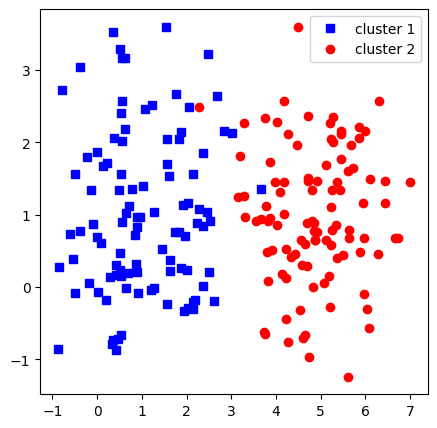

In [ ]:
fig = plt.figure(figsize=(5, 5))

plt.plot(data[np.where(labels == 0)[0],0], data[np.where(labels == 0)[0],1], 'bs', label='cluster 1')
plt.plot(data[np.where(labels == 1)[0],0], data[np.where(labels == 1)[0],1], 'ro', label='cluster 2')

plt.legend()
plt.show()

### build model

In [ ]:
ANNclf = nn.Sequential(
    nn.Linear(2,1),
    nn.ReLU(),
    nn.Linear(1,1),
    nn.Sigmoid()
)
ANNclf

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): Sigmoid()
)

In [ ]:
learningRate = 0.01
lossFunc = nn.BCELoss()    # Binary Cross Entropy Loss
optimizer = torch.optim.SGD(ANNclf.parameters(), lr=learningRate)

### 모델 train

In [ ]:
num_epochs = 1000
losses = torch.zeros(num_epochs)

for epoch in range(num_epochs):
  yhat = ANNclf(data)
  loss = lossFunc(yhat, labels)
  losses[epoch] = loss

  # backward propagation
  optimizer.zero_grad()    # gradient 값 초기화
  loss.backward()    # 계산된 loss값을 기반으로 각 파라미터에 대한 gradient 계산
  optimizer.step()    # 모델의 파라미터 업데이트

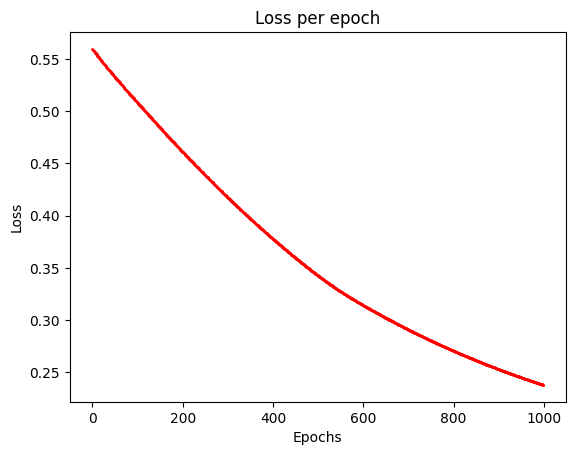

In [ ]:
plt.plot(losses.detach(), 'ro', ms=1)
plt.title('Loss per epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### prediction & accuracy

In [ ]:
pred_prob = ANNclf(data)
pred = pred_prob > 0.5

In [ ]:
miss = np.where(pred != labels)[0]
accuracy = 100 - 100 * len(miss) / len(labels)
accuracy

93.5

In [ ]:
x_miss, y_miss = data[miss,0], data[miss,1]
x_true, y_true = data[np.where(pred)[0],0], data[np.where(pred)[0],1]
x_false, y_false = data[np.where(~pred)[0],0], data[np.where(~pred)[0],1]

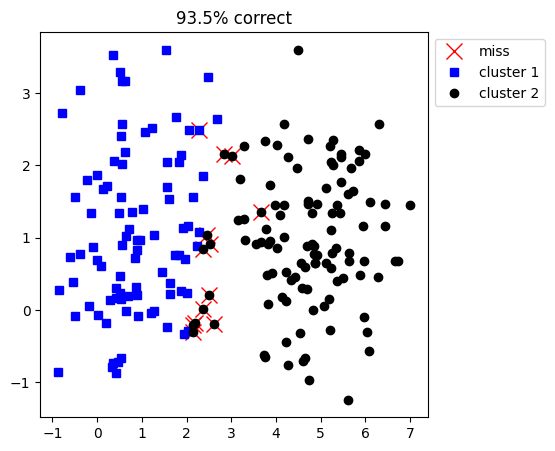

In [ ]:
# plot the labeled data
fig = plt.figure(figsize=(5, 5))
plt.plot(x_miss, y_miss, 'rx', ms=12, label='miss')
plt.plot(x_false, y_false, 'bs', label='cluster 1')
plt.plot(x_true, y_true, 'ko', label='cluster 2')

plt.title(f"{accuracy}% correct")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

## Experiment with function

### 데이터 생성기

In [ ]:
def genData(nPerClust=100, blur=1, A=[1, 1], B=[5, 1]):
  """데이터 포인트를 생성하여 반환합니다.

  두 개의 클러스터를 생성하고, 각 클러스터에 속하는 데이터 포인트를 생성합니다.
  데이터 포인트는 정규 분포를 따르며, 클러스터 중심과 blur 값에 따라 분포가 결정됩니다.

  Args:
    nPerClust: 각 클러스터에 생성할 데이터 포인트의 개수입니다. 기본값은 100입니다.
    blur: 데이터 포인트의 분포를 조절하는 값입니다. 값이 클수록 데이터 포인트가 더 넓게 분포합니다. 기본값은 1입니다.
    A: 첫 번째 클러스터의 중심 좌표입니다. 기본값은 [1, 1]입니다.
    B: 두 번째 클러스터의 중심 좌표입니다. 기본값은 [5, 1]입니다.

  Returns:
    NumPy 배열: 생성된 데이터 포인트를 포함하는 배열입니다.
                배열의 각 행은 하나의 데이터 포인트를 나타내고,
                각 열은 데이터 포인트의 x, y 좌표를 나타냅니다.
  """
  a = [ A[0]+np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur ]
  b = [ B[0]+np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur ]

  data_np = np.hstack((a,b)).T                                                          # (x,y) 좌표들 생성, 데이터를 샘플별로 정리할 때 자주 사용
  labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))))            # label 컬럼 생성

  data = torch.tensor(data_np).float()
  labels = torch.tensor(labels_np).float()

  return data, labels

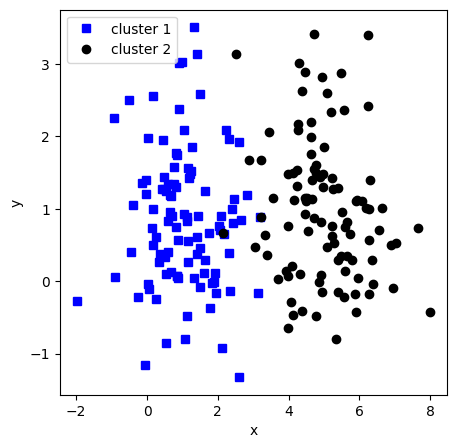

In [ ]:
data,labels = genData()

cluster1 = data[np.where(labels==0)[0], : ]
cluster2 = data[np.where(labels==1)[0], : ]

fig = plt.figure(figsize=(5,5))
plt.plot(cluster1[:,0], cluster1[:,1], 'bs', label='cluster 1')
plt.plot(cluster2[:,0], cluster2[:,1], 'ko', label='cluster 2')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

plt.show()

### 학습기

In [ ]:
def sANNclf(X,y, learningRate=0.01, num_epochs=1000):
  """단순 인공 신경망 (ANN) 분류기를 학습시킵니다.

  이 함수는 제공된 데이터와 매개변수를 사용하여 단순 ANN 분류기를 생성, 학습 및 평가합니다.

  Args:
    X: 입력 데이터 텐서.
    y: 대상 레이블 텐서.
    learningRate: 옵티마이저의 학습률. 기본값은 0.01입니다.
    num_epochs: 학습 에포크 수. 기본값은 1000입니다.

  Returns:
    다음을 포함하는 튜플:
      - losses: 에포크에 따른 손실 텐서.
      - pred: 예측된 레이블.
      - total_acc: 분류기의 전체 정확도.
  """
  # model building
  ANNclf = nn.Sequential(
      nn.Linear(2,1),            # input layer
      nn.ReLU(),                 # activation function
      nn.Linear(1,1),            # output layer
      #nn.Sigmoid()              #  not needed b/c BCEWithLogitsLoss
  )

  lossfn = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(ANNclf.parameters(), lr=learningRate)

  # train the model
  losses = torch.zeros(num_epochs)
  for epoch in range(num_epochs):
    yhat = ANNclf(data)

    loss = lossfn(yhat, labels)
    losses[epoch] = loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  pred = ANNclf(data)

  total_acc = 100*torch.mean(((pred>0) ==labels).float())    # !!! not >0.5, 괄호 조심 a>b=c는 (a>b) and (b=c)

  return losses, pred, total_acc

### experiment

In [ ]:
data,labels = genData()
num_epochs = 1000

lrs = np.linspace(0.001, 0.1, 51)
accs = np.zeros(len(lrs))
all_losses = np.zeros((len(lrs), num_epochs))

for i,lr in enumerate(lrs):
  losses, pred, acc = sANNclf(data, labels, learningRate=lr, num_epochs=num_epochs)
  accs[i] = acc
  all_losses[i,:] = losses.detach()

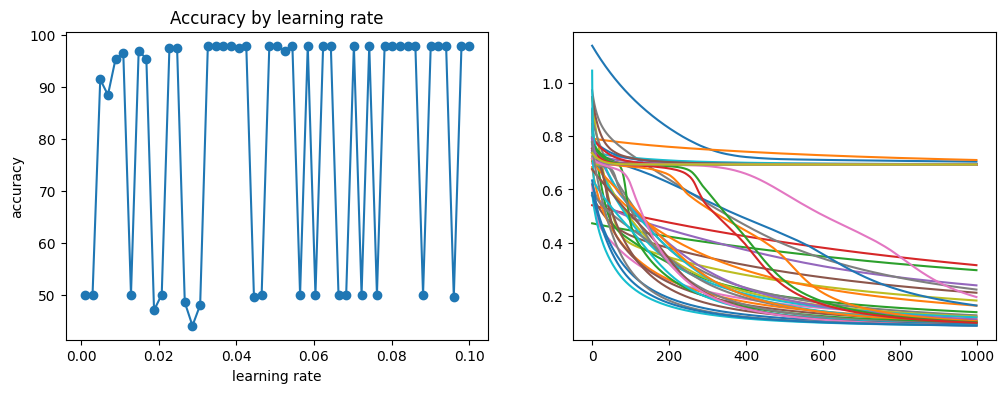

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(lrs, accs, 'o-')
ax[0].set_xlabel('learning rate')
ax[0].set_ylabel('accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(all_losses.T)

plt.show()

(0.0, 4.0)

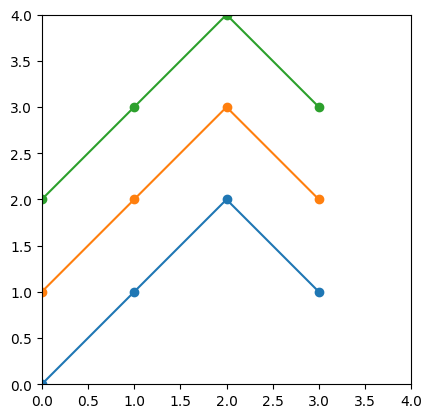

In [ ]:
X =np.array([
              [0,1,2],
              [1,2,3],
              [2,3,4],
              [1,2,3]
            ]
)

plt.plot(X,'o-')
plt.axis('square')
plt.xlim([0,4])
plt.ylim([0,4])